### Import Packages and Download Dataset

In [22]:
import kagglehub
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large

In [23]:
PATH = kagglehub.dataset_download("asefjamilajwad/car-crash-dataset-ccd")
print(PATH)

C:\Users\Weiwei\.cache\kagglehub\datasets\asefjamilajwad\car-crash-dataset-ccd\versions\2


### Load Data and Preprocessing

In [24]:
DATA_PATH = os.path.join(PATH, "CrashBest")
TABLE_PATH = os.path.join(PATH, "Crash_Table.csv")

TARGET_SIZE = (224, 224)

In [25]:
df = pd.read_csv(TABLE_PATH)
df.head()

,vidname,frame_1,frame_2,frame_3,frame_4,frame_5,frame_6,frame_7,frame_8,frame_9,frame_10,frame_11,frame_12,frame_13,frame_14,frame_15,frame_16,frame_17,frame_18,frame_19,frame_20,frame_21,frame_22,frame_23,frame_24,frame_25,frame_26,frame_27,frame_28,frame_29,frame_30,frame_31,frame_32,frame_33,frame_34,frame_35,frame_36,frame_37,frame_38,frame_39,frame_40,frame_41,frame_42,frame_43,frame_44,frame_45,frame_46,frame_47,frame_48,frame_49,frame_50,startframe,youtubeID,timing,weather,egoinvolve
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,285,0,Day,Normal,Yes
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,646,0,Day,Normal,Yes
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,972,0,Day,Normal,Yes
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1257,0,Day,Normal,Yes
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,462,10,Day,Snowy,Yes


In [26]:
df_sampled = df.sample(100, random_state=40)

In [27]:
def get_file_name(video_name, frame_name):
  return f"C_{video_name:06}_{frame_name:02}.jpg"

def get_video_frame_paths(video_name):
  frame_paths = []
  for i in range (1, 51):
    frame_path = os.path.join(DATA_PATH, get_file_name(video_name, i))
    frame_paths.append(frame_path)
  return frame_paths

In [28]:
video_names = []
raw_images =[]
labels = []
timings = []

for idx, row in df_sampled.iterrows():
  frame_paths = get_video_frame_paths(row["vidname"])
  if all(os.path.exists(frame_path) for frame_path in frame_paths):
    for frame_path in frame_paths:
      image = cv2.imread(frame_path)
      image = cv2.resize(image, TARGET_SIZE)
      raw_images.append(image)
      
    for i in range(1, 51):
      labels.append(row[f"frame_{i}"])
      timings.append(row["timing"])
      video_names.append(row["vidname"])

print("Length of video_names: ", len(video_names))
print("Length of image_paths: ", len(raw_images))
print("Length of labels: ", len(labels))
print("Length of timings: ", len(timings))

Length of video_names:  5000
Length of image_paths:  5000
Length of labels:  5000
Length of timings:  5000


In [29]:
x_train, x_temp, y_train, y_temp = train_test_split(raw_images, labels, test_size=0.2, random_state=40)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=40)

In [30]:
model = MobileNetV3Large(include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

12683000/12683000 [==============================] - 2s 0us/step


In [31]:
x = model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(50, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
EPOCHS = 10
BATCH_SIZE = 32

In [34]:
history = model.fit(np.array(x_train), np.array(y_train), epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(np.array(x_val), np.array(y_val)))

Epoch 1/10
125/125 [==============================] - 60s 444ms/step - loss: 0.7686 - accuracy: 0.8495 - val_loss: 0.3309 - val_accuracy: 0.8900
Epoch 2/10
125/125 [==============================] - 51s 409ms/step - loss: 0.1224 - accuracy: 0.9597 - val_loss: 0.1396 - val_accuracy: 0.9420
Epoch 3/10
125/125 [==============================] - 53s 425ms/step - loss: 0.0926 - accuracy: 0.9737 - val_loss: 0.1628 - val_accuracy: 0.9500
Epoch 4/10
125/125 [==============================] - 50s 403ms/step - loss: 0.0413 - accuracy: 0.9868 - val_loss: 0.1419 - val_accuracy: 0.9540
Epoch 5/10
125/125 [==============================] - 50s 399ms/step - loss: 0.0356 - accuracy: 0.9893 - val_loss: 0.1526 - val_accuracy: 0.9540
Epoch 6/10
125/125 [==============================] - 52s 412ms/step - loss: 0.0369 - accuracy: 0.9898 - val_loss: 0.1276 - val_accuracy: 0.9600
Epoch 7/10
125/125 [==============================] - 53s 423ms/step - loss: 0.0162 - accuracy: 0.9962 - val_loss: 0.1228 - val_ac

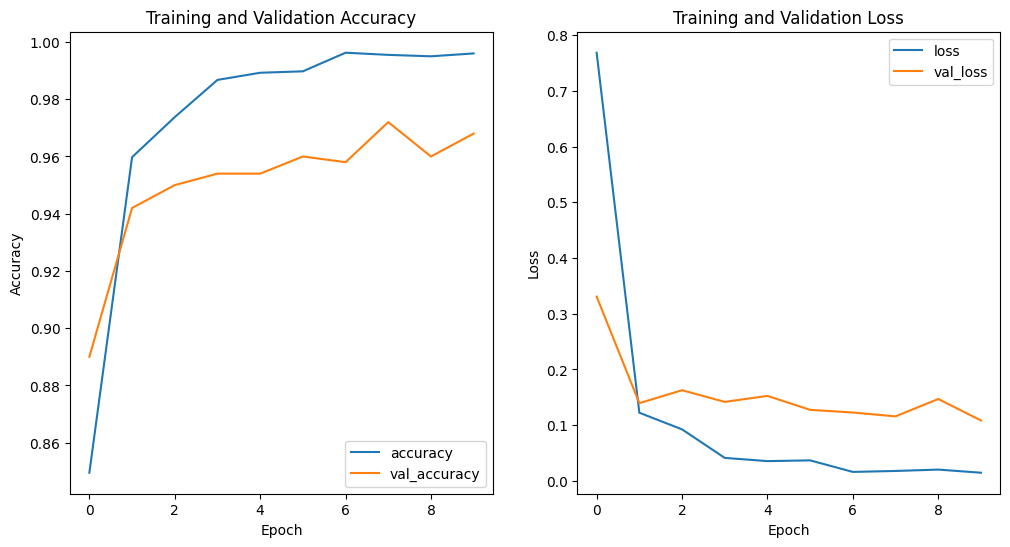

In [35]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [36]:
test_loss, test_acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=2)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

16/16 - 5s - loss: 0.1381 - accuracy: 0.9620 - 5s/epoch - 325ms/step
Test accuracy: 0.9620000123977661
Test loss: 0.1380988210439682


In [37]:
y_pred = model.predict(np.array(x_test))
y_pred = np.round(y_pred)

print("True Labels vs. Predicted Labels:")
for i in range(10):
  print(f"True Label: {int(y_test[i])}, Predicted Label: {int(y_pred[i])}")

16/16 [==============================] - 7s 349ms/step
True Labels vs. Predicted Labels:
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 1
True Label: 1, Predicted Label: 1
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 0, Predicted Label: 0
True Label: 1, Predicted Label: 1


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       358
           1       0.96      0.90      0.93       142

    accuracy                           0.96       500
   macro avg       0.96      0.94      0.95       500
weighted avg       0.96      0.96      0.96       500



<Figure size 800x600 with 0 Axes>

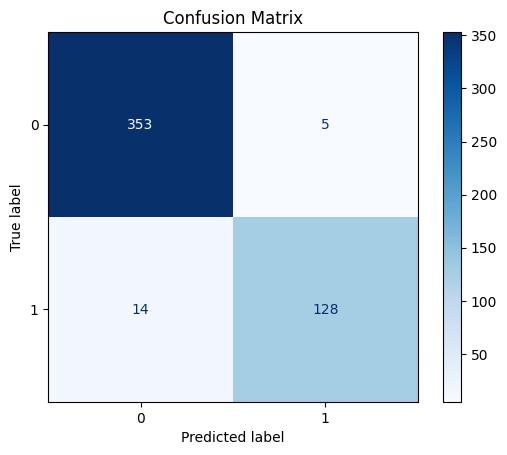

In [39]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [40]:
model.save('models/mobilenetv3.keras')